In [9]:
from __future__ import division
import numpy as np
import os
import sys
import time
import functools
import pickle
import multiprocess
from sklearn.utils import shuffle
from algorithms import Problem
import utils
%load_ext autoreload
%autoreload 2

In [32]:
show_fig = True
save_fig = True
save_data = True

## Similarity Matrix Creation

In [33]:
iclr_data = np.load('iclr2018_all.npz')
iclr_similarity = iclr_data['similarity_matrix']
iclr_author_mask = iclr_data['mask_matrix']

row_idx = np.where(iclr_author_mask == 1)[0]
col_idx = np.where(iclr_author_mask == 1)[1]
iclr_similarity[row_idx, col_idx] = 0

save_dir = os.path.join(os.getcwd(), 'UAI_FIGS_ICLR_FINAL4')
data_dir = os.path.join(os.getcwd(), 'UAI_DATA_ICLR_FINAL4')

## Gain and Bidding Functions

In [34]:
# Gain functions for paper-side gain.                     
sqrt = lambda d: np.sqrt(d)
minimum_3 = lambda d: np.minimum(d, 3)
minimum_5 = lambda d: np.minimum(d, 5)
minimum_6 = lambda d: np.minimum(d, 6)
minimum_10 = lambda d: np.minimum(d, 10)

# Gain functions for reviewer-side gain.
def DCG(s, pi=None): 
    if pi is None:
        return (2.**(s)-1)
    else:
        return (2.**(s)-1)/np.log2(pi + 1)
    
def DCG_sqrt(s, pi=None): 
    if pi is None: 
        return (2.**(s)-1) 
    else: 
        return (2.**(s)-1)/np.sqrt(pi)

# Bidding functions.
def bid_log(s, pi=None): 
    if pi is None:
        return s
    else:
        return s/np.log2(pi + 1)
    
def bid_sqrt(s, pi=None): 
    if pi is None:
        return s
    else:
        return s/np.sqrt(pi)

## Function to Simulate All Algorithms

In [36]:
def simulate_all(s_list, g_p, g_r, f, f_tilde, noise, hyper, special, stop, poisson, subset, seed, verbose=True):

    start = time.time()
    super_mean_heuristic = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, 
                                     hyper=hyper, special=special, stop=stop, poisson=poisson, subset=subset)
    super_mean_heuristic.simulate(super_mean_heuristic.super_mean_heuristic_policy, seed)
    end = time.time()

    if verbose:
        print('finish mean heuristic', end-start)

    start = time.time()
    super_zero_heuristic = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                                   special=special, stop=stop, poisson=poisson, subset=subset)
    super_zero_heuristic.simulate(super_zero_heuristic.super_zero_heuristic_policy, seed)
    end = time.time()

    if verbose:
        print('finish zero heuristic', end-start)

    start = time.time()
    sim = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                  special=special, stop=stop, poisson=poisson, subset=subset)
    sim.simulate(sim.sim_policy, seed)
    end = time.time()

    if verbose:
        print('finish sim', end-start)

    start = time.time()
    bid = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                  special=special, stop=stop, poisson=poisson, subset=subset)
    bid.simulate(bid.bid_policy, seed)
    end = time.time()

    if verbose:
        print('finish bid', end-start)

    start = time.time()
    random = Problem(s=s_list, g_p=g_p, g_r=g_r, f=f, f_tilde=f_tilde, noise=noise, hyper=hyper, 
                     special=special, stop=stop, poisson=poisson, subset=subset)
    random.simulate(random.random_policy, seed)
    end = time.time()

    if verbose:
        print('finish random', end-start)

    algs = [super_mean_heuristic, super_zero_heuristic, sim, bid, random]

    return algs

## Simulation Set 1: Standard Parameters

('finish mean heuristic', 30.93999719619751)
('finish zero heuristic', 30.828383922576904)
('finish sim', 32.240350008010864)
('finish bid', 31.332244157791138)
('finish random', 14.141340970993042)
('finish mean heuristic', 35.565463066101074)
('finish zero heuristic', 31.6008620262146)
('finish sim', 33.14183497428894)
('finish bid', 36.85358119010925)
('finish random', 14.485864162445068)
('finish mean heuristic', 38.345683097839355)
('finish zero heuristic', 38.16205883026123)
('finish sim', 37.286723136901855)
('finish bid', 36.87332201004028)
('finish random', 14.76451301574707)
('finish mean heuristic', 36.598673820495605)
('finish zero heuristic', 36.52568984031677)
('finish sim', 36.129724979400635)
('finish bid', 35.6963849067688)
('finish random', 14.812565088272095)
('finish mean heuristic', 36.95997714996338)
('finish zero heuristic', 37.13766312599182)
('finish sim', 36.37644720077515)
('finish bid', 34.960675954818726)
('finish random', 12.520942211151123)
('finish mean 

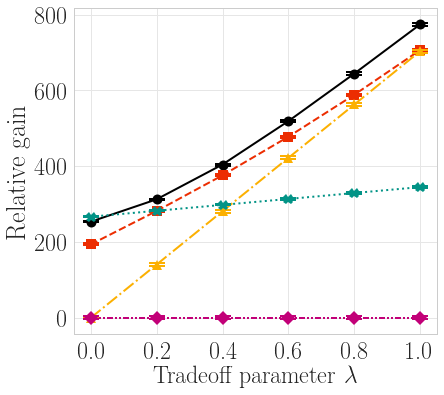

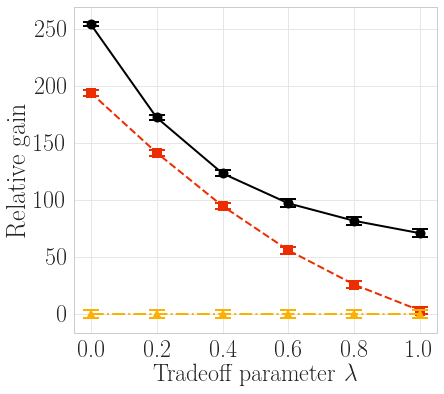

[[  1.   7.  16.   0.  13.]
 [ 57.  49. 126.  22. 138.]
 [358. 317. 240. 425. 302.]
 [495. 538. 529. 463. 458.]]


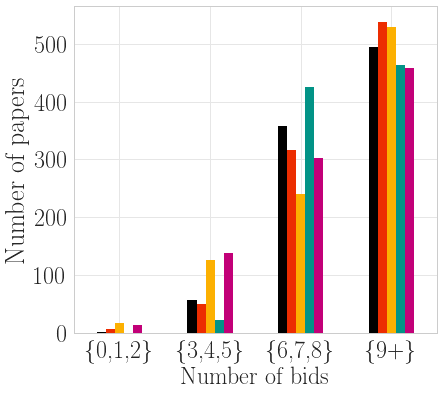

[[  1.   7.  16.]
 [ 57.  49. 126.]
 [358. 317. 240.]
 [495. 538. 529.]]


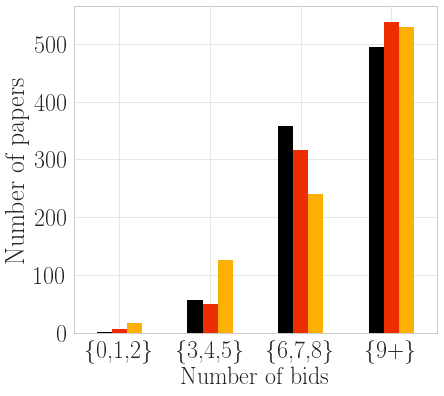

In [37]:
hyper_range = np.arange(0, 1.1, .2)

hyper_range_set = [hyper_range]
gain_function_set = [minimum_6]
name1 = 'min6_normal_all'
name2 = 'min6_normal_gain'

num = 0
for g_p, hyper_range in zip(gain_function_set, hyper_range_set):

    full_all_data = []
    full_gain_data = []

    for hyper in hyper_range:
        g_r = DCG
        f = bid_log
        f_tilde = bid_log
        noise = 0
        special = True
        stop = lambda x: x
        poisson = False
        subset = False
        seed = 0
        count = 20        

        np.random.seed(seed)
        
        s_list = [shuffle(iclr_similarity) for _ in xrange(count)]
        
        algs = simulate_all(s_list, g_p, g_r, f, f_tilde, noise, hyper, special, stop, poisson, subset, seed, verbose=True)

        all_data = [(algs[i].gain_mean, algs[i].p_gain_mean, algs[i].r_gain_mean, algs[i].r_gain_unweighted_mean, algs[i].bid_history) for i in xrange(len(algs))]
        gain_data = [(algs[i].gain_mean, algs[i].gain_se) for i in xrange(len(algs))]

        full_all_data.append(all_data)
        full_gain_data.append(gain_data)
        
    hyper_range = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    utils.sweep_comparison_plot(full_gain_data, hyper_range, 'Tradeoff parameter $\lambda$', os.path.join(save_dir, 'min6.pdf'), show_fig, save_fig)
    utils.sweep_comparison_plot_sim_base(full_gain_data, hyper_range, 'Tradeoff parameter $\lambda$', os.path.join(save_dir, 'min6_base.pdf'), show_fig, save_fig)

    hyper_index = 4
    index = None
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2, 3, 4]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'min6_bids.pdf'), show_fig, save_fig)

    hyper_index = 4
    index = None
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'min6_bids_base.pdf'), show_fig, save_fig)

    if save_data:
        pickle.dump(full_all_data, open(os.path.join(data_dir, name1+str(num)+'.p'), 'wb'))
        pickle.dump(full_gain_data, open(os.path.join(data_dir, name2+str(num)+'.p'), 'wb'))
    num += 1

## Simulation Set 2: Varying Parameters

('finish mean heuristic', 38.17916703224182)
('finish zero heuristic', 34.47051191329956)
('finish sim', 34.446348905563354)
('finish bid', 36.627660036087036)
('finish random', 13.981787919998169)
('finish mean heuristic', 37.56674098968506)
('finish zero heuristic', 35.92201590538025)
('finish sim', 37.52459120750427)
('finish bid', 39.4974479675293)
('finish random', 14.57984209060669)
('finish mean heuristic', 38.84484791755676)
('finish zero heuristic', 38.3547260761261)
('finish sim', 39.25839614868164)
('finish bid', 35.98591899871826)
('finish random', 13.524240970611572)
('finish mean heuristic', 35.66223502159119)
('finish zero heuristic', 38.69858694076538)
('finish sim', 36.357197999954224)
('finish bid', 33.38056707382202)
('finish random', 14.290420055389404)
('finish mean heuristic', 36.24459195137024)
('finish zero heuristic', 33.41548204421997)
('finish sim', 36.77788186073303)
('finish bid', 32.697097063064575)
('finish random', 13.063201904296875)
('finish mean heuri

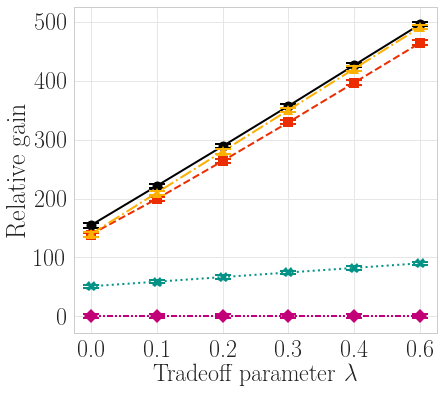

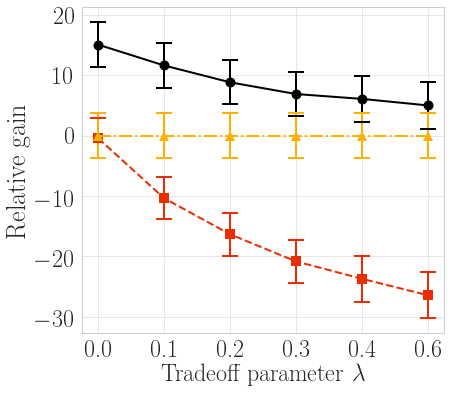

[[ 12.   7.  16.   0.  13.]
 [111. 100. 126.  22. 138.]
 [244. 257. 240. 425. 302.]
 [544. 546. 529. 463. 458.]]


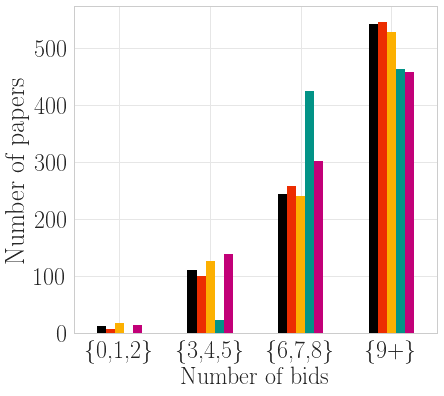

[[ 12.   7.  16.]
 [111. 100. 126.]
 [244. 257. 240.]
 [544. 546. 529.]]


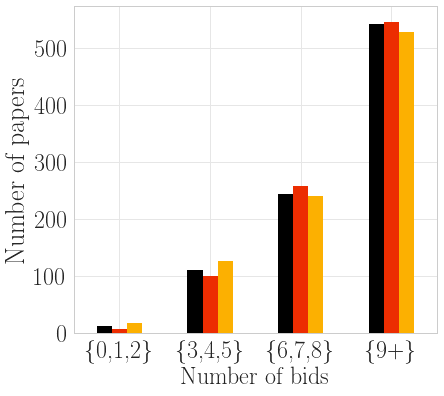

('finish mean heuristic', 34.84715294837952)
('finish zero heuristic', 34.5658061504364)
('finish sim', 33.98480296134949)
('finish bid', 33.223488092422485)
('finish random', 13.554174900054932)
('finish mean heuristic', 35.360349893569946)
('finish zero heuristic', 34.453197956085205)
('finish sim', 34.69498300552368)
('finish bid', 34.024717807769775)
('finish random', 13.828679084777832)
('finish mean heuristic', 35.99874997138977)
('finish zero heuristic', 34.630977153778076)
('finish sim', 37.787237882614136)
('finish bid', 33.171178102493286)
('finish random', 13.528141975402832)
('finish mean heuristic', 32.902791023254395)
('finish zero heuristic', 31.36218500137329)
('finish sim', 31.652288913726807)
('finish bid', 33.74498891830444)
('finish random', 12.926284074783325)
('finish mean heuristic', 37.62584209442139)
('finish zero heuristic', 34.80101203918457)
('finish sim', 33.64761400222778)
('finish bid', 33.055197954177856)
('finish random', 13.300382137298584)
('finish me

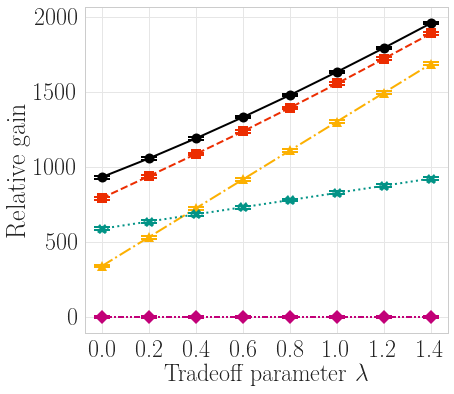

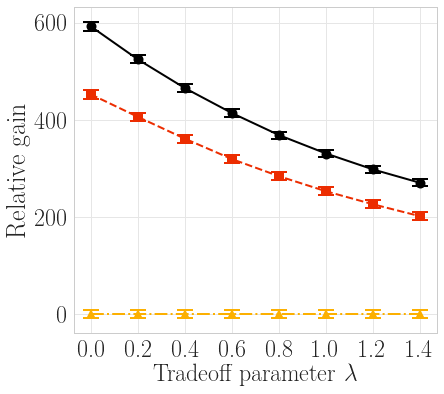

[[ 64. 101. 158.   0. 175.]
 [288. 242. 312. 701. 454.]
 [517. 464. 238. 204. 235.]
 [ 42. 104. 202.   6.  46.]]


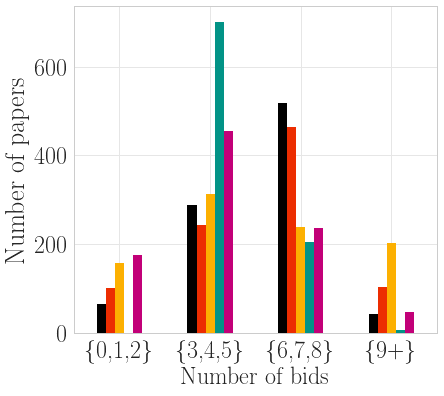

[[ 64. 101. 158.]
 [288. 242. 312.]
 [517. 464. 238.]
 [ 42. 104. 202.]]


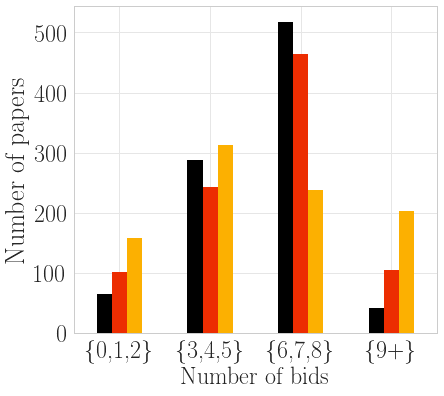

In [39]:
hyper_range1 = np.arange(0.0, 0.6, 0.1)
hyper_range2 = np.arange(0, 1.5, .2)

hyper_range_set = [hyper_range1, hyper_range2]
parameter_sets = [(sqrt, bid_log, DCG), (minimum_6, bid_sqrt, DCG_sqrt)]
name1 = 'param_vary_all'
name2 = 'param_vary_gain'

num = 0
for param_set, hyper_range in zip(parameter_sets, hyper_range_set):

    full_all_data = []
    full_gain_data = []

    for hyper in hyper_range:
        g_p = param_set[0]
        g_r = param_set[2]
        f = param_set[1]
        f_tilde = param_set[1]
        noise = 0
        special = True
        stop = lambda x: x
        poisson = False
        subset = False
        seed = 0
        count = 20        

        np.random.seed(seed)
        
        s_list = [shuffle(iclr_similarity) for _ in xrange(count)]
        
        algs = simulate_all(s_list, g_p, g_r, f, f_tilde, noise, hyper, special, stop, poisson, subset, seed, verbose=True)

        all_data = [(algs[i].gain_mean, algs[i].p_gain_mean, algs[i].r_gain_mean, algs[i].r_gain_unweighted_mean, algs[i].bid_history) for i in xrange(len(algs))]
        gain_data = [(algs[i].gain_mean, algs[i].gain_se) for i in xrange(len(algs))]

        full_all_data.append(all_data)
        full_gain_data.append(gain_data)
        
    if num == 0:
        hyper_range = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.6])
    elif num == 1:
        hyper_range = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])

    utils.sweep_comparison_plot(full_gain_data, hyper_range, 'Tradeoff parameter $\lambda$', os.path.join(save_dir, 'param_set' + str(num) + '.pdf'), show_fig, save_fig)
    utils.sweep_comparison_plot_sim_base(full_gain_data, hyper_range, 'Tradeoff parameter $\lambda$', os.path.join(save_dir,'param_set' + str(num) + 'base.pdf'), show_fig, save_fig)

    if num == 0:
        hyper_index = 4
    elif num == 1:
        hyper_index = 6
    index = None
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2, 3, 4]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'param_set' + str(num) + 'bids.pdf'), show_fig, save_fig)

    if num == 0:
        hyper_index = 4
    elif num == 1:
        hyper_index = 6
    index = None
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'param_set' + str(num) + 'bids_base.pdf'), show_fig, save_fig)

    if save_data:
        pickle.dump(full_all_data, open(os.path.join(data_dir, name1+str(num)+'.p'), 'wb'))
        pickle.dump(full_gain_data, open(os.path.join(data_dir, name2+str(num)+'.p'), 'wb'))
    num += 1

## Simulation Set 3: Robustness

('finish mean heuristic', 33.31022000312805)
('finish zero heuristic', 31.86075496673584)
('finish sim', 33.937050104141235)
('finish bid', 35.72810196876526)
('finish random', 14.454732894897461)
('finish mean heuristic', 33.885021924972534)
('finish zero heuristic', 33.54756188392639)
('finish sim', 35.515204191207886)
('finish bid', 35.403870820999146)
('finish random', 12.553420066833496)
('finish mean heuristic', 30.877842903137207)
('finish zero heuristic', 28.790817975997925)
('finish sim', 31.73641085624695)
('finish bid', 31.510188102722168)
('finish random', 12.54849100112915)
('finish mean heuristic', 29.960756063461304)
('finish zero heuristic', 28.681622982025146)
('finish sim', 31.447407007217407)
('finish bid', 31.247640132904053)
('finish random', 12.249520063400269)
('finish mean heuristic', 29.90707278251648)
('finish zero heuristic', 28.843881130218506)
('finish sim', 31.372047901153564)
('finish bid', 31.352202892303467)
('finish random', 12.327119827270508)
('finis

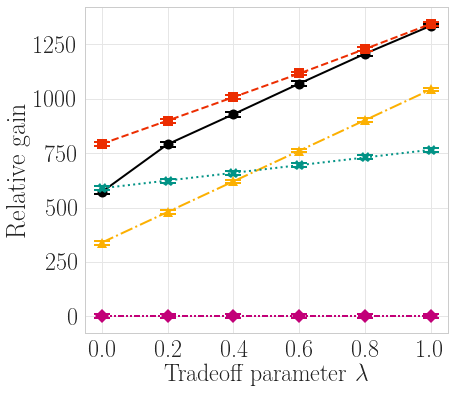

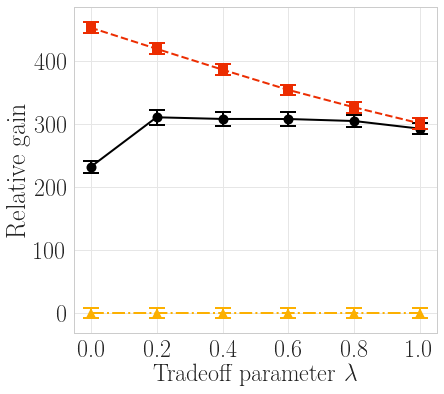

[[ 25.  98. 158.   0. 175.]
 [479. 240. 312. 701. 454.]
 [350. 486. 238. 204. 235.]
 [ 57.  87. 202.   6.  46.]]


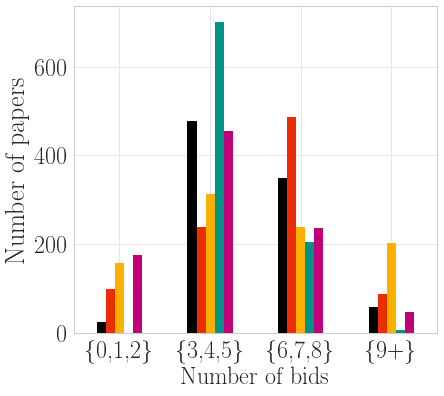

[[ 25.  98. 158.]
 [479. 240. 312.]
 [350. 486. 238.]
 [ 57.  87. 202.]]


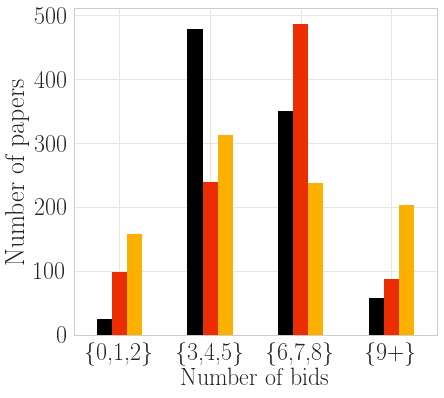

('finish mean heuristic', 30.42124605178833)
('finish zero heuristic', 28.75925302505493)
('finish sim', 33.83941316604614)
('finish bid', 33.79394292831421)
('finish random', 14.559547901153564)
('finish mean heuristic', 33.17797517776489)
('finish zero heuristic', 32.11402201652527)
('finish sim', 41.981831073760986)
('finish bid', 42.28972816467285)
('finish random', 18.071866989135742)
('finish mean heuristic', 186.91476011276245)
('finish zero heuristic', 38.64264798164368)
('finish sim', 37.42690992355347)
('finish bid', 35.03304314613342)
('finish random', 13.101820945739746)
('finish mean heuristic', 34.497987031936646)
('finish zero heuristic', 32.65161490440369)
('finish sim', 35.104995012283325)
('finish bid', 35.244977951049805)
('finish random', 13.80312705039978)
('finish mean heuristic', 32.776652097702026)
('finish zero heuristic', 32.886494159698486)
('finish sim', 35.70845699310303)
('finish bid', 35.84574604034424)
('finish random', 13.86956000328064)
('finish mean h

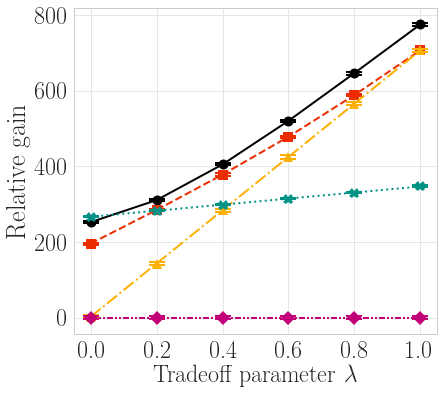

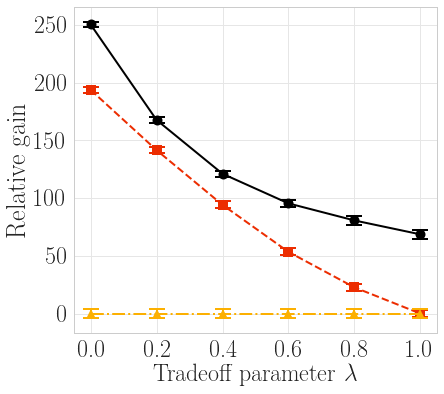

[[  1.   6.  15.   0.  13.]
 [ 56.  52. 126.  20. 138.]
 [358. 313. 239. 428. 303.]
 [496. 540. 530. 463. 457.]]


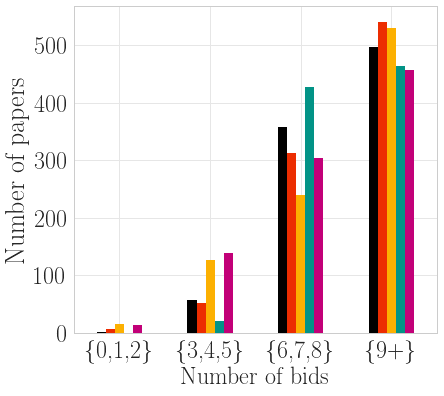

[[  1.   6.  15.]
 [ 56.  52. 126.]
 [358. 313. 239.]
 [496. 540. 530.]]


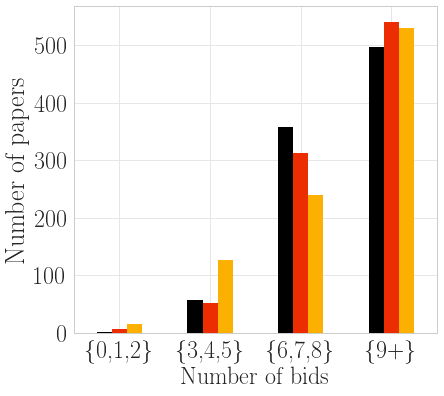

('finish mean heuristic', 24.651927947998047)
('finish zero heuristic', 24.691070079803467)
('finish sim', 26.436702966690063)
('finish bid', 25.683510065078735)
('finish random', 11.227882146835327)
('finish mean heuristic', 24.2586989402771)
('finish zero heuristic', 23.760395050048828)
('finish sim', 25.85963201522827)
('finish bid', 26.01269006729126)
('finish random', 10.656884908676147)
('finish mean heuristic', 24.40654993057251)
('finish zero heuristic', 25.15098810195923)
('finish sim', 27.462032079696655)
('finish bid', 25.599885940551758)
('finish random', 10.656803846359253)
('finish mean heuristic', 24.605796098709106)
('finish zero heuristic', 23.582401990890503)
('finish sim', 25.81528091430664)
('finish bid', 26.95373010635376)
('finish random', 10.779153823852539)
('finish mean heuristic', 26.072779178619385)
('finish zero heuristic', 24.165825843811035)
('finish sim', 28.048624992370605)
('finish bid', 28.030907154083252)
('finish random', 10.92314100265503)
('finish 

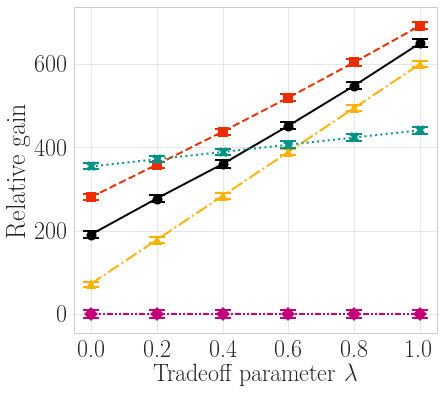

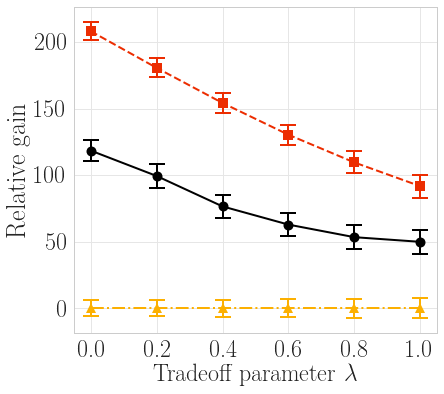

[[  7.  35.  53.   0.  53.]
 [308. 190. 251. 288. 294.]
 [334. 422. 304. 464. 352.]
 [263. 264. 303. 158. 212.]]


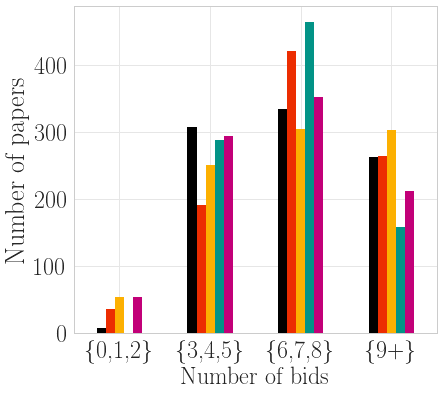

[[  7.  35.  53.]
 [308. 190. 251.]
 [334. 422. 304.]
 [263. 264. 303.]]


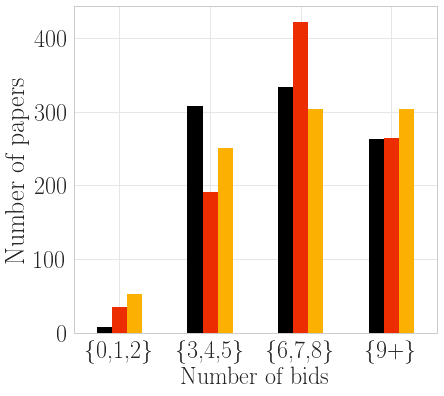

('finish mean heuristic', 32.76159405708313)
('finish zero heuristic', 32.35062313079834)
('finish sim', 38.067291021347046)
('finish bid', 37.68499183654785)
('finish random', 14.947139978408813)
('finish mean heuristic', 34.71392893791199)
('finish zero heuristic', 34.407232999801636)
('finish sim', 38.82223391532898)
('finish bid', 38.31375694274902)
('finish random', 15.719114065170288)
('finish mean heuristic', 35.30592703819275)
('finish zero heuristic', 34.036680936813354)
('finish sim', 36.312652826309204)
('finish bid', 36.95214796066284)
('finish random', 14.87364912033081)
('finish mean heuristic', 34.556785106658936)
('finish zero heuristic', 33.558120012283325)
('finish sim', 34.94539999961853)
('finish bid', 37.77207899093628)
('finish random', 16.304744005203247)
('finish mean heuristic', 35.036093950271606)
('finish zero heuristic', 33.21798610687256)
('finish sim', 38.744073152542114)
('finish bid', 37.983136892318726)
('finish random', 15.03438687324524)
('finish mean

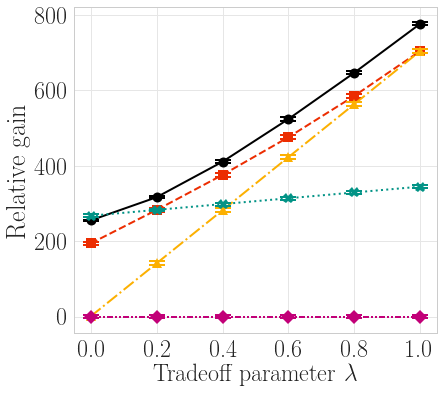

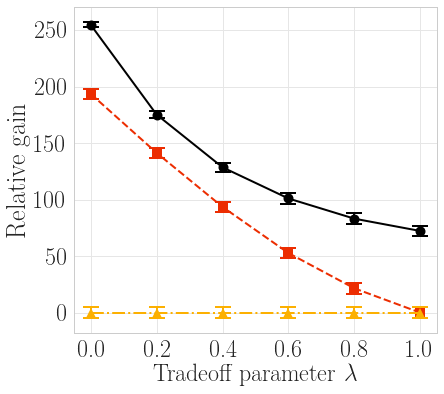

[[  1.   6.  18.   0.  15.]
 [ 61.  55. 125.  26. 137.]
 [355. 313. 240. 426. 300.]
 [495. 537. 528. 460. 460.]]


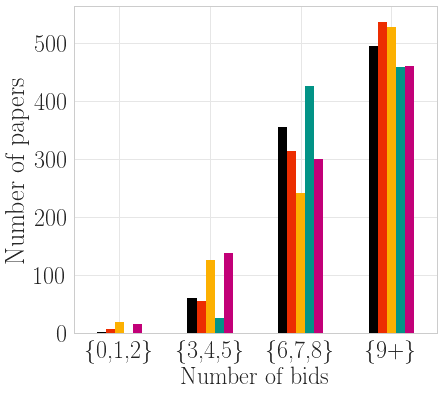

[[  1.   6.  18.]
 [ 61.  55. 125.]
 [355. 313. 240.]
 [495. 537. 528.]]


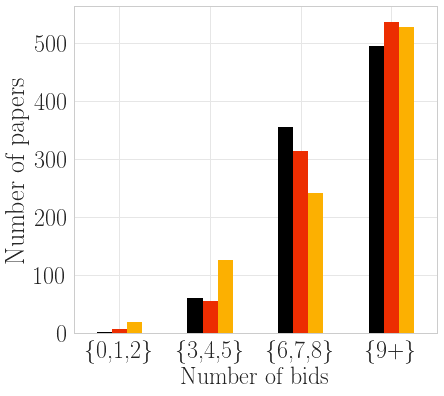

In [40]:
hyper_range = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
parameter_sets = [(bid_sqrt, 0, lambda x: x, False), (bid_log, 0.01, lambda x:x, False), (bid_log, 0, lambda x:int(3*x/4), False), (bid_log, 0, lambda x:x, True)]
name1 = 'robust_all'
name2 = 'robust_gain'

num = 0
for param_set in parameter_sets:

    full_all_data = []
    full_gain_data = []

    for hyper in hyper_range:
        g_p = minimum_6
        g_r = DCG
        f = bid_log
        f_tilde = param_set[0]
        noise = param_set[1]
        special = True
        stop = param_set[2]
        poisson = param_set[3]
        subset = False
        seed = 0
        count = 20        

        np.random.seed(seed)
        
        s_list = [shuffle(iclr_similarity) for _ in xrange(count)]
        
        algs = simulate_all(s_list, g_p, g_r, f, f_tilde, noise, hyper, special, stop, poisson, subset, seed, verbose=True)

        all_data = [(algs[i].gain_mean, algs[i].p_gain_mean, algs[i].r_gain_mean, algs[i].r_gain_unweighted_mean, algs[i].bid_history) for i in xrange(len(algs))]
        gain_data = [(algs[i].gain_mean, algs[i].gain_se) for i in xrange(len(algs))]

        full_all_data.append(all_data)
        full_gain_data.append(gain_data)
        
    utils.sweep_comparison_plot(full_gain_data, hyper_range, 'Tradeoff parameter $\lambda$', os.path.join(save_dir, 'robust' + str(num) + '.pdf'), show_fig, save_fig)
    utils.sweep_comparison_plot_sim_base(full_gain_data, hyper_range, 'Tradeoff parameter $\lambda$', os.path.join(save_dir,'robust' + str(num) + 'base.pdf'), show_fig, save_fig)

    hyper_index = 4
    index = None
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2, 3, 4]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'robust' + str(num) + 'bids.pdf'), show_fig, save_fig)

    hyper_index = 4
    index = None
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'robust' + str(num) + 'bids_base.pdf'), show_fig, save_fig)

    if save_data:
        pickle.dump(full_all_data, open(os.path.join(data_dir, name1+str(num)+'.p'), 'wb'))
        pickle.dump(full_gain_data, open(os.path.join(data_dir, name2+str(num)+'.p'), 'wb'))
    num += 1

## Simulation Set 4: Varying Similarity Matrix

In [41]:
from scipy.linalg import block_diag
s_func_block = lambda pair: np.random.uniform(0, .05, (pair[0], pair[1])) +block_diag(*[np.random.uniform(.7, .7)*np.ones((25,25)) for i in range(int(pair[0]/25))])

s_func_inter = lambda pair: np.vstack([np.hstack([.17*np.ones((int(pair[0]/2), int(.4*pair[1]))), .005*np.ones((int(pair[0]/2), int(.4*pair[1]))), .085*np.ones((int(pair[0]/2), int(.2*pair[1])))]), 
                            np.hstack([.005*np.ones((int(pair[0]/2), int(.4*pair[1]))), .17*np.ones((int(pair[0]/2), int(.4*pair[1]))), .085*np.ones((int(pair[0]/2), int(.2*pair[1])))])])

s_func_beta = lambda pair: np.random.beta(1, 15, pair)
s_func_low_rank = lambda pair: np.vstack([np.dot(np.ones(int(pair[0]/10)).reshape(-1, 1), np.random.beta(i, 60, pair[1]).reshape(1, -1)) for i in range(1, 11)])

('finish mean heuristic', 1.4043989181518555)
('finish zero heuristic', 1.5177769660949707)
('finish sim', 1.4302139282226562)
('finish bid', 1.3948969841003418)
('finish random', 0.7513740062713623)
('finish mean heuristic', 4.5547239780426025)
('finish zero heuristic', 4.345350980758667)
('finish sim', 4.760707139968872)
('finish bid', 4.573347091674805)
('finish random', 2.050326108932495)
('finish mean heuristic', 9.404374122619629)
('finish zero heuristic', 9.050699949264526)
('finish sim', 9.880829095840454)
('finish bid', 9.831581115722656)
('finish random', 4.067754030227661)
('finish mean heuristic', 15.615376949310303)
('finish zero heuristic', 15.520835876464844)
('finish sim', 16.802051067352295)
('finish bid', 16.767192840576172)
('finish random', 6.6247169971466064)


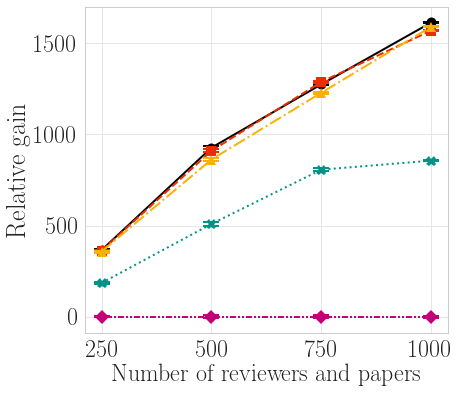

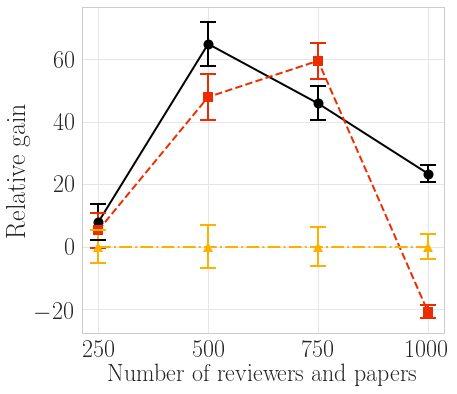

[[  1.   4.  11.   0.  44.]
 [ 75.  79. 140. 162. 276.]
 [463. 418. 303. 486. 305.]
 [212. 248. 295. 102. 125.]]


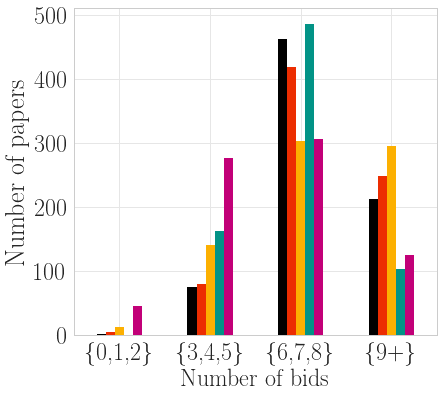

[[  1.   4.  11.]
 [ 75.  79. 140.]
 [463. 418. 303.]
 [212. 248. 295.]]


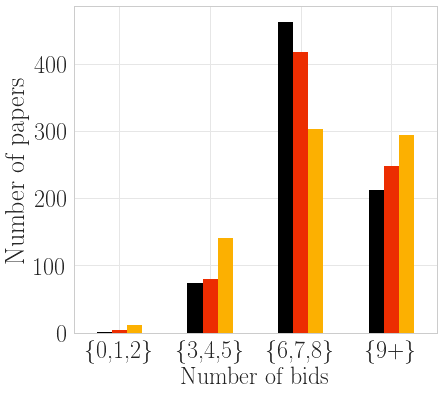

('finish mean heuristic', 1.378350019454956)
('finish zero heuristic', 1.37888503074646)
('finish sim', 1.4964048862457275)
('finish bid', 1.4103188514709473)
('finish random', 0.7388279438018799)
('finish mean heuristic', 4.46999716758728)
('finish zero heuristic', 4.395525932312012)
('finish sim', 4.803277969360352)
('finish bid', 4.69021201133728)
('finish random', 2.0384109020233154)
('finish mean heuristic', 9.095836877822876)
('finish zero heuristic', 9.104712963104248)
('finish sim', 9.814254999160767)
('finish bid', 9.789977073669434)
('finish random', 4.1468729972839355)
('finish mean heuristic', 15.54276704788208)
('finish zero heuristic', 15.33350419998169)
('finish sim', 17.2417471408844)
('finish bid', 16.65891194343567)
('finish random', 6.649529933929443)


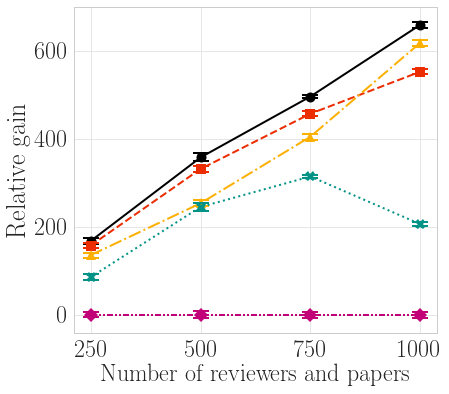

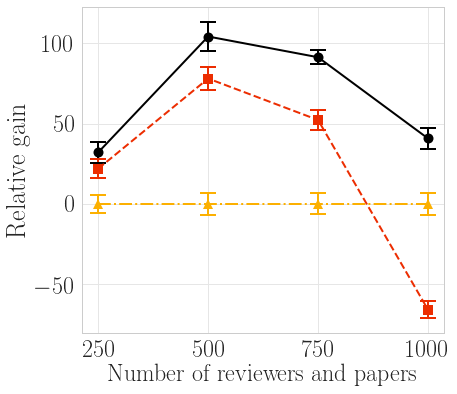

[[  0.   6.  14.   0.  14.]
 [ 62.  62. 133.  47. 142.]
 [369. 324. 250. 420. 293.]
 [319. 358. 352. 284. 302.]]


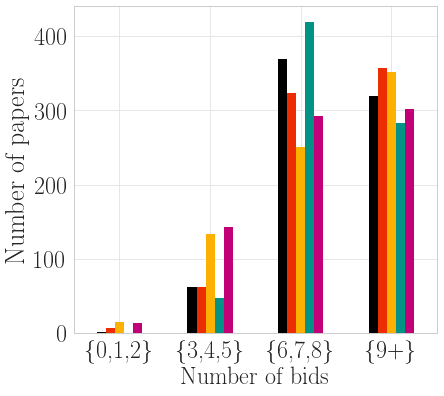

[[  0.   6.  14.]
 [ 62.  62. 133.]
 [369. 324. 250.]
 [319. 358. 352.]]


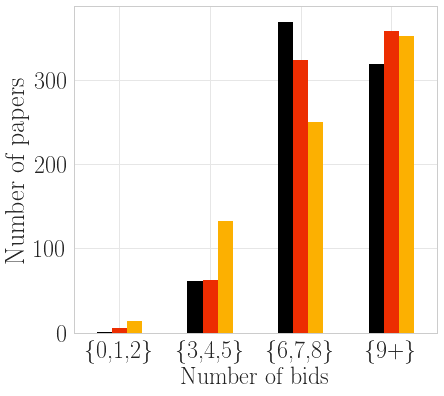

('finish mean heuristic', 1.352588176727295)
('finish zero heuristic', 1.3141379356384277)
('finish sim', 1.4201149940490723)
('finish bid', 1.3535940647125244)
('finish random', 0.6794300079345703)
('finish mean heuristic', 4.435117959976196)
('finish zero heuristic', 4.29074501991272)
('finish sim', 4.629981994628906)
('finish bid', 4.6372082233428955)
('finish random', 2.407191038131714)
('finish mean heuristic', 10.374824047088623)
('finish zero heuristic', 8.711248874664307)
('finish sim', 9.733670949935913)
('finish bid', 9.57878303527832)
('finish random', 4.199702024459839)
('finish mean heuristic', 15.903654098510742)
('finish zero heuristic', 14.988525867462158)
('finish sim', 17.57720685005188)
('finish bid', 17.84635901451111)
('finish random', 6.399212121963501)


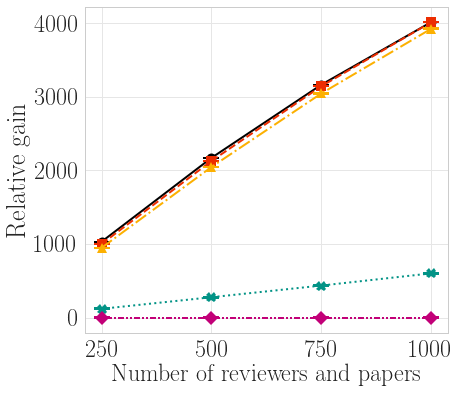

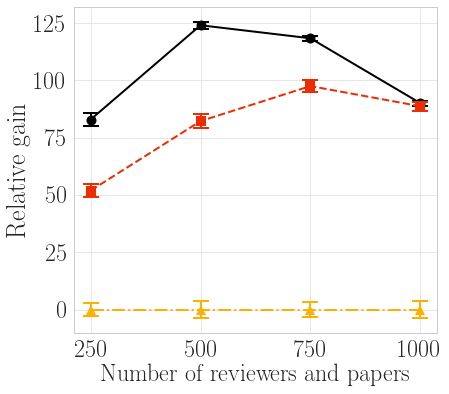

[[  0.   1.   4.  31. 110.]
 [ 26.  37.  98. 456. 393.]
 [419. 392. 306. 241. 213.]
 [306. 320. 342.  22.  35.]]


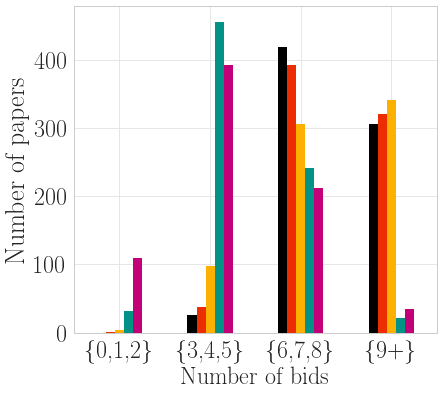

[[  0.   1.   4.]
 [ 26.  37.  98.]
 [419. 392. 306.]
 [306. 320. 342.]]


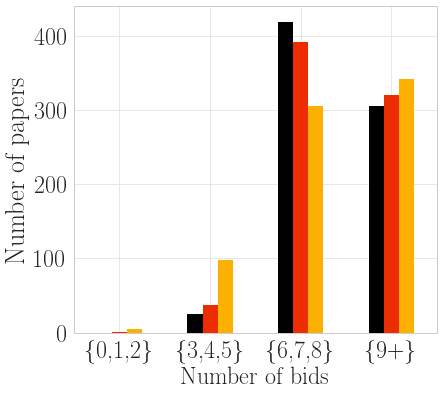

('finish mean heuristic', 1.4064621925354004)
('finish zero heuristic', 1.4118640422821045)
('finish sim', 1.3865230083465576)
('finish bid', 1.4140219688415527)
('finish random', 0.7459189891815186)
('finish mean heuristic', 4.344738006591797)
('finish zero heuristic', 4.038110971450806)
('finish sim', 4.611702919006348)
('finish bid', 4.2129809856414795)
('finish random', 1.8867831230163574)
('finish mean heuristic', 8.169842958450317)
('finish zero heuristic', 7.911195993423462)
('finish sim', 9.247488021850586)
('finish bid', 8.82960319519043)
('finish random', 3.8946120738983154)
('finish mean heuristic', 14.105890035629272)
('finish zero heuristic', 13.595650911331177)
('finish sim', 15.326288938522339)
('finish bid', 15.19367003440857)
('finish random', 6.415572166442871)


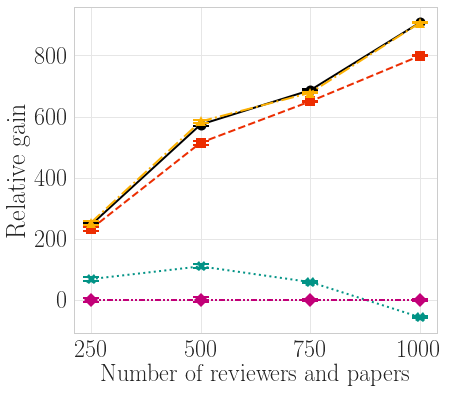

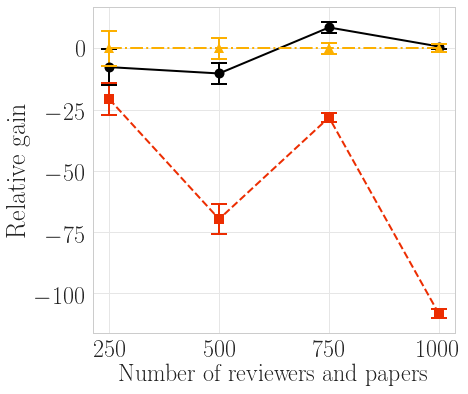

[[ 0.  0.  2.  0.  1.]
 [12. 11. 33. 13. 24.]
 [86. 75. 66. 81. 58.]
 [52. 63. 49. 55. 67.]]


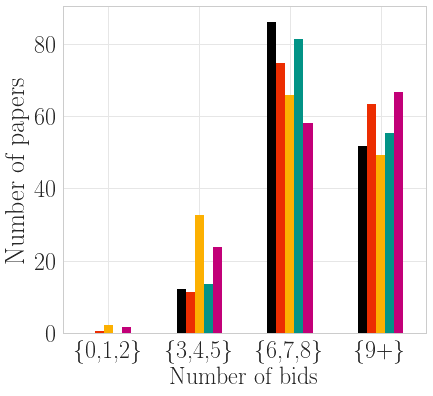

[[ 0.  0.  2.]
 [12. 11. 33.]
 [86. 75. 66.]
 [52. 63. 49.]]


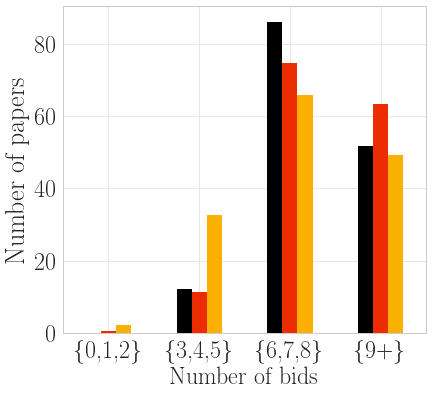

In [42]:
name1 = 'vary_sim_all'
name2 = 'vary_sim_gain'
param_list = [(250,250), (500,500), (750,750), (1000,1000)]
s_func_list = [s_func_beta, s_func_low_rank, s_func_block, s_func_inter]

num = 0
for s_func in s_func_list:

    full_all_data = []
    full_gain_data = []

    for pair in param_list:
        g_p = minimum_6
        g_r = DCG
        f = bid_log
        f_tilde = bid_log
        hyper = 0.8
        noise = 0
        special = True
        stop = lambda x: x
        poisson = False
        subset = False
        seed = 0
        count = 20      

        np.random.seed(seed)
        
        s_list = [s_func(pair) for _ in xrange(count)]
        
        algs = simulate_all(s_list, g_p, g_r, f, f_tilde, noise, hyper, special, stop, poisson, subset, seed, verbose=True)

        all_data = [(algs[i].gain_mean, algs[i].p_gain_mean, algs[i].r_gain_mean, algs[i].r_gain_unweighted_mean, algs[i].bid_history) for i in xrange(len(algs))]
        gain_data = [(algs[i].gain_mean, algs[i].gain_se) for i in xrange(len(algs))]

        full_all_data.append(all_data)
        full_gain_data.append(gain_data)
        
    hyper_range = np.array([250, 500, 750, 1000])
    utils.sweep_comparison_plot(full_gain_data, hyper_range, 'Number of reviewers and papers', os.path.join(save_dir, 'matrix' + str(num) + '.pdf'), show_fig, save_fig)
    utils.sweep_comparison_plot_sim_base(full_gain_data, hyper_range, 'Number of reviewers and papers', os.path.join(save_dir,'matrix' + str(num) + 'base.pdf'), show_fig, save_fig)

    if num == 3:
        index = int(param_list[hyper_index][0]*.8)
    else:
        index = None
    hyper_index = 2
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2, 3, 4]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'matrix' + str(num) + 'bids.pdf'), show_fig, save_fig)

    hyper_index = 2
    intervals = [(0, 2), (3, 5), (6, 8), (9, 10)]
    alg_set = [0, 1, 2]
    endpoint = False
    bid_count_data = full_all_data
    utils.plot_bid_count_data(bid_count_data, hyper_index, intervals, alg_set, endpoint, index, os.path.join(save_dir, 'matrix' + str(num) + 'bids_base.pdf'), show_fig, save_fig)

    if save_data:
        pickle.dump(full_all_data, open(os.path.join(data_dir, name1+str(num)+'.p'), 'wb'))
        pickle.dump(full_gain_data, open(os.path.join(data_dir, name2+str(num)+'.p'), 'wb'))
    num += 1